# Libraries

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ta
from math import sqrt
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Cleaning and preprocessing

In [127]:
# =============== HELPER FOR ISO WEEK ===============
def get_isoweeks(dt_index):
    """Returns a NumPy array of iso week numbers (1..53)."""
    return np.array([ts.isocalendar()[1] for ts in dt_index], dtype=int)

# =============== 1) LOAD & WEEKLY RESAMPLE ===============
df = pd.read_csv("apple_stock.csv")
df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df = df.resample("W").mean().dropna()

# Example: keep ~15 years
cutoff = df.index.max() - pd.DateOffset(years=15)
df = df[df.index >= cutoff].copy()

# Final test = last 4 weeks
final_test_weeks = 4
df_test = df.iloc[-final_test_weeks:].copy()
df_cv   = df.iloc[:-final_test_weeks].copy()  # everything up to the test

print("df_cv covers:", df_cv.index.min(), "to", df_cv.index.max())
print("df_test covers:", df_test.index.min(), "to", df_test.index.max())

df_cv covers: 2010-01-10 00:00:00 to 2024-12-08 00:00:00
df_test covers: 2024-12-15 00:00:00 to 2025-01-05 00:00:00


In [128]:
# =============== 2) DECOMPOSE df_cv (no peeking at test) ===============
# >>> FIX: avoid losing last dates by two_sided=False & extrapolate_trend='freq'
decomp = seasonal_decompose(
    df_cv["Close"], 
    model="additive", 
    period=52, 
    two_sided=False, 
    extrapolate_trend='freq'
)
df_cv["trend"]    = decomp.trend
df_cv["seasonal"] = decomp.seasonal
df_cv["resid"]    = decomp.resid

# We typically won't need to dropna now; no final rows should be lost.
# But if there's any edge NaN leftover, do minimal cleanup:
df_cv.dropna(subset=["trend","seasonal","resid"], inplace=True)

df_cv["Close_orig"] = df_cv["Close"]   # store actual
df_cv["Close"]      = df_cv["resid"]   # LSTM predicts residual

# Feature Engineering & Hyperparameter Tuning

In [129]:
# =============== 3) ADD INDICATORS (ON ORIGINAL CLOSE) ===============
df_cv["RSI"] = ta.momentum.rsi(df_cv["Close_orig"], 2)
df_cv["MACD"] = ta.trend.macd(df_cv["Close_orig"])
df_cv["MACD_Signal"] = ta.trend.macd_signal(df_cv["Close_orig"])
df_cv["BB_High"] = ta.volatility.bollinger_hband(df_cv["Close_orig"])
df_cv["BB_Low"]  = ta.volatility.bollinger_lband(df_cv["Close_orig"])
df_cv["Daily_Return"]   = df_cv["Close_orig"].pct_change()
df_cv["RollingMean_20"] = df_cv["Close_orig"].rolling(3).mean()
df_cv["RollingStd_20"]  = df_cv["Close_orig"].rolling(3).std()
df_cv.fillna(0, inplace=True)

In [130]:
# =============== 4) TIME-BASED CV FUNCTION ===============
def time_based_cv(data_df, num_folds=2, weeks_per_fold=4, param_grid=None):
    all_idx = data_df.index
    n = len(all_idx)

    c_orig = data_df["Close_orig"].to_numpy()
    t_     = data_df["trend"].to_numpy()
    s_     = data_df["seasonal"].to_numpy()
    r_     = data_df["Close"].to_numpy()  # residual

    base_day = all_idx[0]
    numeric_t = np.array([(dt - base_day).days for dt in all_idx]).reshape(-1,1)

    feat_cols = [
        "trend","seasonal","RSI","MACD","MACD_Signal","BB_High","BB_Low",
        "Daily_Return","RollingMean_20","RollingStd_20"
    ]

    def get_fold_indices(fold_i):
        val_start = n - weeks_per_fold*(num_folds - fold_i)
        val_end   = val_start + weeks_per_fold
        return range(0, val_start), range(val_start, val_end)

    results = []
    run_count = 0
    start_time= time.time()
    total_runs= len(param_grid)*num_folds

    for hp in param_grid:
        fold_mses = []
        for fold_i in range(num_folds):
            run_count += 1
            tr_idx, va_idx = get_fold_indices(fold_i)

            close_train_part = c_orig[list(tr_idx)]
            steps = len(va_idx)

            # ARIMA on the train portion
            arima_model = ARIMA(close_train_part, order=(1,1,1))
            arima_fit   = arima_model.fit()
            close_forecast = arima_fit.forecast(steps=steps)

            # Forecast-based indicators
            tail_window = 30
            hist_cl = np.concatenate([close_train_part[-tail_window:], close_forecast])
            
            tr_tail_idx = [all_idx[i] for i in tr_idx][-tail_window:]
            va_ts       = [all_idx[i] for i in va_idx]
            combined_idx= tr_tail_idx + va_ts

            tmp_df = pd.DataFrame({"Close": hist_cl}, index=combined_idx)
            tmp_df["RSI"] = ta.momentum.rsi(tmp_df["Close"], 2)
            tmp_df["MACD"] = ta.trend.macd(tmp_df["Close"])
            tmp_df["MACD_Signal"] = ta.trend.macd_signal(tmp_df["Close"])
            tmp_df["BB_High"] = ta.volatility.bollinger_hband(tmp_df["Close"])
            tmp_df["BB_Low"]  = ta.volatility.bollinger_lband(tmp_df["Close"])
            tmp_df["Daily_Return"]   = tmp_df["Close"].pct_change()
            tmp_df["RollingMean_20"] = tmp_df["Close"].rolling(3).mean()
            tmp_df["RollingStd_20"]  = tmp_df["Close"].rolling(3).std()
            tmp_df.fillna(0, inplace=True)

            val_feat_part = tmp_df.loc[va_ts]

            # Forecast trend+seasonal from train portion
            numeric_t_train = numeric_t[list(tr_idx)]
            trend_train_slice = t_[list(tr_idx)]
            valid_mask = ~np.isnan(trend_train_slice)

            lr = LinearRegression()
            lr.fit(numeric_t_train[valid_mask].reshape(-1,1), trend_train_slice[valid_mask])
            numeric_t_val = numeric_t[list(va_idx)]
            trend_val_pred= lr.predict(numeric_t_val)

            def get_weeks_local(dts):
                return np.array([ts.isocalendar()[1] for ts in dts])

            train_weeks = get_weeks_local([all_idx[i] for i in tr_idx])
            s_map = pd.Series(s_[list(tr_idx)], index=train_weeks).groupby(level=0).mean()

            val_weeks = get_weeks_local(va_ts)
            seasonal_val_pred = np.array([s_map.get(w,0) for w in val_weeks])
            seasonal_val_pred = np.where(np.isnan(seasonal_val_pred), 0, seasonal_val_pred)

            X_tr_slice = data_df.iloc[list(tr_idx)][feat_cols].to_numpy()
            y_tr_slice = r_[list(tr_idx)].reshape(-1,1)

            val_data = pd.DataFrame({
                "trend": trend_val_pred,
                "seasonal": seasonal_val_pred,
                "RSI": val_feat_part["RSI"],
                "MACD": val_feat_part["MACD"],
                "MACD_Signal": val_feat_part["MACD_Signal"],
                "BB_High": val_feat_part["BB_High"],
                "BB_Low":  val_feat_part["BB_Low"],
                "Daily_Return": val_feat_part["Daily_Return"],
                "RollingMean_20": val_feat_part["RollingMean_20"],
                "RollingStd_20":  val_feat_part["RollingStd_20"]
            }, index=val_feat_part.index)

            X_va_slice = val_data[feat_cols].to_numpy()
            y_va_true  = r_[list(va_idx)].reshape(-1,1)

            sc_x = MinMaxScaler()
            sc_y = MinMaxScaler()
            X_tr_s = sc_x.fit_transform(X_tr_slice)
            y_tr_s = sc_y.fit_transform(y_tr_slice)
            X_va_s = sc_x.transform(X_va_slice)
            y_va_s = sc_y.transform(y_va_true)

            X_tr_s = X_tr_s.reshape(-1,1,X_tr_s.shape[1])
            X_va_s = X_va_s.reshape(-1,1,X_va_s.shape[1])

            model = Sequential()
            for _ in range(hp["layers"]):
                model.add(LSTM(hp["units"], return_sequences=False))
                model.add(Dropout(hp["dropout"]))
            model.add(Dense(1))
            model.compile(loss="mse", optimizer=Adam(learning_rate=hp["lr"]))

            model.fit(X_tr_s, y_tr_s, epochs=hp["epochs"], 
                      batch_size=hp["batch_size"], verbose=0)

            preds_val = model.predict(X_va_s).ravel()
            mse_val = np.mean((preds_val - y_va_s.ravel())**2)
            fold_mses.append(mse_val)

            elapsed = time.time() - start_time
            avg_t   = elapsed/run_count
            left    = (total_runs - run_count)*avg_t/60
            print(f"Fold {fold_i+1}/{num_folds}, HP={hp}, MSE={mse_val:.5f}, ~{left:.1f}m left.")

        results.append((hp, np.mean(fold_mses)))

    results.sort(key=lambda x: x[1])
    return results[0]

# =============== 5) RUN CV ON df_cv (no gap) ===============
param_grid = [
  {"units":16,"layers":1,"dropout":0.2,"lr":1e-3,"batch_size":32,"epochs":100},
  {"units":32,"layers":1,"dropout":0.3,"lr":5e-4,"batch_size":32,"epochs":100},
]
best_hp, best_cv_mse = time_based_cv(df_cv, num_folds=4, weeks_per_fold=4, param_grid=param_grid)
print("Best HP:", best_hp)
print("Best CV MSE:", best_cv_mse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Fold 1/4, HP={'units': 16, 'layers': 1, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32, 'epochs': 100}, MSE=0.00442, ~0.3m left.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Fold 2/4, HP={'units': 16, 'layers': 1, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32, 'epochs': 100}, MSE=0.00629, ~0.2m left.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Fold 3/4, HP={'units': 16, 'layers': 1, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32, 'epochs': 100}, MSE=0.01742, ~0.2m left.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Fold 4/4, HP={'units': 16, 'layers': 1, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32, 'epochs': 100}, MSE=0.06896, ~0.2m left.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Fold 1/4, HP={'units': 32, 'layers': 1, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}, MSE=0.01056, ~0.1m left.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Fold 2/4, HP={'units': 32, 'layers': 1, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32, 'epochs': 100}, MSE=0.03798, ~0.1m left.
1/

# Evaluation

In [131]:
# =============== 6) RETRAIN ON df_cv & FORECAST TEST ===============
close_cv_full = df_cv["Close_orig"].to_numpy()
arima_full  = ARIMA(close_cv_full, order=(1,1,1)).fit()
close_test_fore = arima_full.forecast(steps=final_test_weeks)

# Indicators from forecasted close
tail_window = 30
hist_cl = np.concatenate([close_cv_full[-tail_window:], close_test_fore])
hist_idx= list(df_cv.index[-tail_window:]) + list(df_test.index)

tmp_test = pd.DataFrame({"Close":hist_cl}, index=hist_idx)
tmp_test["RSI"] = ta.momentum.rsi(tmp_test["Close"], 2)
tmp_test["MACD"] = ta.trend.macd(tmp_test["Close"])
tmp_test["MACD_Signal"] = ta.trend.macd_signal(tmp_test["Close"])
tmp_test["BB_High"] = ta.volatility.bollinger_hband(tmp_test["Close"])
tmp_test["BB_Low"]  = ta.volatility.bollinger_lband(tmp_test["Close"])
tmp_test["Daily_Return"]   = tmp_test["Close"].pct_change()
tmp_test["RollingMean_20"] = tmp_test["Close"].rolling(3).mean()
tmp_test["RollingStd_20"]  = tmp_test["Close"].rolling(3).std()
tmp_test.fillna(0, inplace=True)

# Trend+Seasonal from df_cv
base_day = df_cv.index[0]
cv_t = np.array([(dt - base_day).days for dt in df_cv.index]).reshape(-1,1)
trend_cv = df_cv["trend"].to_numpy()
val_mask = ~np.isnan(trend_cv)

lr = LinearRegression()
lr.fit(cv_t[val_mask], trend_cv[val_mask])

test_t = np.array([(dt - base_day).days for dt in df_test.index]).reshape(-1,1)
trend_test_pred = lr.predict(test_t)

cv_weeks= get_isoweeks(df_cv.index)
s_map = pd.Series(df_cv["seasonal"].to_numpy(), index=cv_weeks).groupby(level=0).mean()

test_weeks = get_isoweeks(df_test.index)
seasonal_test_pred = np.array([s_map.get(w,0) for w in test_weeks])

feat_cols = [
    "trend","seasonal","RSI","MACD","MACD_Signal","BB_High","BB_Low",
    "Daily_Return","RollingMean_20","RollingStd_20"
]
X_cv_full = df_cv[feat_cols].to_numpy()
y_cv_full = df_cv["Close"].to_numpy().reshape(-1,1)

sc_x_full = MinMaxScaler()
sc_y_full = MinMaxScaler()
X_cv_sc = sc_x_full.fit_transform(X_cv_full)
y_cv_sc = sc_y_full.fit_transform(y_cv_full)

X_cv_sc = X_cv_sc.reshape(-1,1,X_cv_sc.shape[1])

final_model = Sequential()
for _ in range(best_hp["layers"]):
    final_model.add(LSTM(best_hp["units"], return_sequences=False))
    final_model.add(Dropout(best_hp["dropout"]))
final_model.add(Dense(1))
final_model.compile(loss="mse", optimizer=Adam(learning_rate=best_hp["lr"]))

final_model.fit(X_cv_sc, y_cv_sc, epochs=best_hp["epochs"], 
                batch_size=best_hp["batch_size"], verbose=0)

# Build test features
test_feat_df = pd.DataFrame(index=df_test.index)
test_feat_df["trend"]    = trend_test_pred
test_feat_df["seasonal"] = seasonal_test_pred

for c in ["RSI","MACD","MACD_Signal","BB_High","BB_Low","Daily_Return","RollingMean_20","RollingStd_20"]:
    test_feat_df[c] = tmp_test.loc[df_test.index, c]

X_test_vals = test_feat_df[feat_cols].to_numpy()
X_test_sc   = sc_x_full.transform(X_test_vals)
X_test_sc   = X_test_sc.reshape(-1,1,X_test_sc.shape[1])

pred_resid_sc = final_model.predict(X_test_sc).ravel()
pred_resid    = sc_y_full.inverse_transform(pred_resid_sc.reshape(-1,1)).ravel()
pred_close    = pred_resid + trend_test_pred + seasonal_test_pred
actual_close  = df_test["Close"]

mse_test  = np.mean((pred_close - actual_close)**2)
rmse_test = sqrt(mse_test)
print("Final Test RMSE:", rmse_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Final Test RMSE: 68.85421164792554


# Plotting

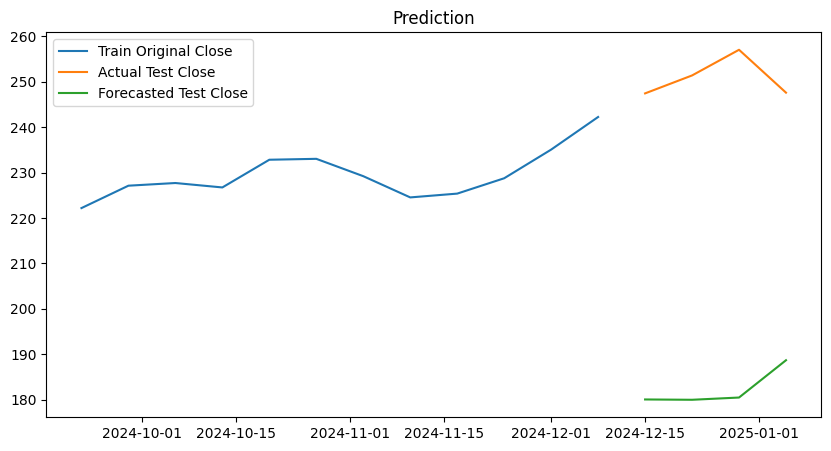

In [132]:
# =============== 7) PLOT: SHOW LAST 12 WEEKS + NO MISSING END ROWS ===============
plt.figure(figsize=(10,5))

# Because we used two_sided=False & extrapolate_trend='freq', 
# the final rows of df_cv are no longer lost. 
# Just plot the last 12 weeks to see it connect seamlessly to test.
train_plot_window = 12
train_tail = df_cv.iloc[-train_plot_window:]  # Now includes final dates

plt.plot(train_tail.index, train_tail["Close_orig"], label="Train Original Close")
plt.plot(df_test.index, actual_close, label="Actual Test Close")
plt.plot(df_test.index, pred_close, label="Forecasted Test Close")

plt.title("Prediction")
plt.legend()
plt.show()